# Exploratory Data Analysis

## Weather

The weather data has not datetime as the other data sets, so it will be created first from the year/month/day/time columns. Then specifying datetime sa index.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

weather = pd.read_csv('weather_kumpula_012019-092022.csv')
weather = weather.rename(columns={'Vuosi': 'year', 'Kk':'month', 'Pv': 'day', 'Klo':'time'})
weather['hour'] = weather['time'].apply(lambda time: int(time[0:2]))
weather['datetime'] = pd.to_datetime(weather[['year','month','day','hour']])
weather = weather.set_index('datetime')

/home/sakorpi/.conda/envs/conda-ml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
weather.tail()

,year,month,day,time,Aikavyöhyke,Pilvien määrä (1/8),Ilmanpaine (msl) (hPa),Sademäärä (mm),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Ilman lämpötila (degC),Tuulen nopeus (m/s),hour
datetime,,,,,,,,,,,,,
2022-09-15 20:00:00,2022,9,15,20:00,UTC,7,987.4,2.5,98,0.4,10.4,1.8,20
2022-09-15 21:00:00,2022,9,15,21:00,UTC,7,987.2,2.7,100,0,11.4,3.9,21
2022-09-15 22:00:00,2022,9,15,22:00,UTC,7,986.9,0,99,0,10.4,1.2,22
2022-09-15 23:00:00,2022,9,15,23:00,UTC,8,987,0,100,0,10.3,1.4,23
2022-09-16 00:00:00,2022,9,16,00:00,UTC,7,986.9,0,100,0,10.1,0.6,0


Then replacing the empty values, expressed as '-' to np.nan. Then changing the types of columns to float. (Integer does not work with np.nan)

In [3]:
weather = weather.replace('-',np.nan)
coltypes = {'Pilvien määrä (1/8)':np.float64, 
            'Ilmanpaine (msl) (hPa)': np.float64,
            'Sademäärä (mm)' : np.float64,
            'Suhteellinen kosteus (%)': np.float64,
            'Sateen intensiteetti (mm/h)':np.float64,
            'Ilman lämpötila (degC)':np.float64,
            'Tuulen nopeus (m/s)':np.float64}

weather = weather.astype(coltypes)

In [4]:
colnames = {'Aikavyöhyke': 'time zone',
            'Pilvien määrä (1/8)': 'clouds', 
            'Ilmanpaine (msl) (hPa)': 'pressure',
            'Sademäärä (mm)' : 'rain',
            'Suhteellinen kosteus (%)': 'humidity',
            'Sateen intensiteetti (mm/h)': 'rain intensitety',
            'Ilman lämpötila (degC)': 'temperature',
            'Tuulen nopeus (m/s)': 'wind'}

weather = weather.rename(columns=colnames)

Replacing na-values with the neighbours values mean. There were very little missing values.

In [5]:
weather['pressure'] = weather['pressure'].ffill().add(weather['pressure'].bfill()).div(2)
weather['rain'] = weather['rain'].ffill().add(weather['rain'].bfill()).div(2)
weather['humidity'] = weather['humidity'].ffill().add(weather['humidity'].bfill()).div(2)
weather['temperature'] = weather['temperature'].ffill().add(weather['temperature'].bfill()).div(2)
weather['wind'] = weather['wind'].ffill().add(weather['wind'].bfill()).div(2)

In [6]:
weather.head()

,year,month,day,time,time zone,clouds,pressure,rain,humidity,rain intensitety,temperature,wind,hour
datetime,,,,,,,,,,,,,
2019-01-01 00:00:00,2019,1,1,00:00,UTC,8.0,1000.9,0.9,97.0,1.1,0.8,7.9,0
2019-01-01 01:00:00,2019,1,1,01:00,UTC,8.0,998.7,2.2,97.0,2.4,1.5,8.5,1
2019-01-01 02:00:00,2019,1,1,02:00,UTC,8.0,996.6,1.7,98.0,0.8,2.0,9.8,2
2019-01-01 03:00:00,2019,1,1,03:00,UTC,8.0,994.2,0.3,98.0,0.0,2.4,8.9,3
2019-01-01 04:00:00,2019,1,1,04:00,UTC,8.0,992.0,0.4,98.0,0.5,2.5,7.6,4


In [65]:
weather = weather.drop(columns=['time','clouds', 'time zone', 'rain intensitety'])
weather['weekday'] = weather.index.day_of_week
weather.head()

,year,month,day,pressure,rain,humidity,temperature,wind,hour,weekday
datetime,,,,,,,,,,
2019-01-01 00:00:00,2019,1,1,1000.9,0.9,97.0,0.8,7.9,0,1
2019-01-01 01:00:00,2019,1,1,998.7,2.2,97.0,1.5,8.5,1,1
2019-01-01 02:00:00,2019,1,1,996.6,1.7,98.0,2.0,9.8,2,1
2019-01-01 03:00:00,2019,1,1,994.2,0.3,98.0,2.4,8.9,3,1
2019-01-01 04:00:00,2019,1,1,992.0,0.4,98.0,2.5,7.6,4,1


<AxesSubplot:title={'center':'Temperature'}, xlabel='datetime'>

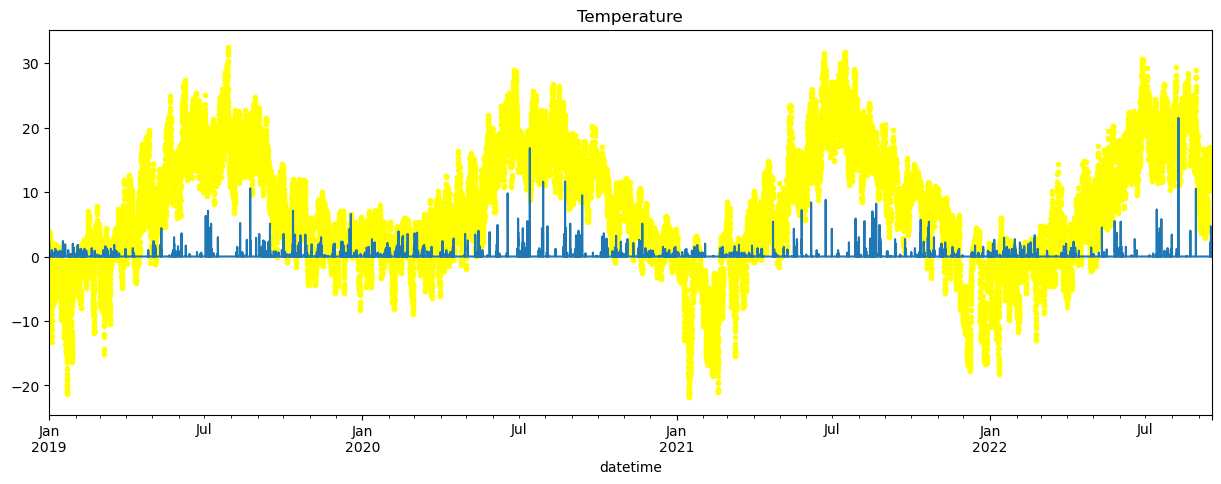

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

weather.loc[:,'temperature'].plot(ax=ax, style='.', color='yellow', figsize=(15,5), title='Temperature')
weather.loc[:,'rain'].plot(ax=ax, style='-', figsize=(15,5), title='Temperature')

In [10]:
weather[['pressure','rain','humidity','temperature','wind']].to_parquet('../data/processed_data/weather.parquet')

Add lags

In [67]:
def add_lags(df, colname, shortname):
    target_map = df[colname].to_dict()
    df[shortname + '_lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df[shortname + '_lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df[shortname + '_lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

weather = add_lags(weather, 'pressure', 'pr')
weather = add_lags(weather, 'rain', 'rain')
weather = add_lags(weather, 'humidity', 'hum')
weather = add_lags(weather, 'temperature', 'temp')
weather = add_lags(weather, 'wind', 'win')

Predict future

In [69]:
def trainmodel(FEATURES, TARGET):
        X_all = weather[FEATURES]
        y_all = weather[TARGET]

        reg = xgb.XGBRegressor(n_estimators=1000)
        reg.fit(X_all, y_all,
                eval_set=[(X_all, y_all)],
                verbose=100)
        return reg

In [70]:
# Create future dataframe
future = pd.date_range(weather.index.max(),'2023-01-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
weather['isFuture'] = False
df_and_future = pd.concat([weather, future_df])
df_and_future = add_lags(df_and_future,'pressure', 'pr')
df_and_future  = add_lags(df_and_future , 'rain', 'rain')
df_and_future  = add_lags(df_and_future , 'humidity', 'hum')
df_and_future  = add_lags(df_and_future , 'temperature', 'temp')
df_and_future  = add_lags(df_and_future , 'wind', 'win')
future_w_features = df_and_future.query('isFuture').copy()

In [76]:
#Fill future table with predictions
FEATURES = ['year','month','pr_lag1','pr_lag2','pr_lag3','hour', 'temperature','wind']
future_w_features['pressure'] = trainmodel(FEATURES, 'pressure').predict(future_w_features[FEATURES])

FEATURES = ['rain_lag1','rain_lag2','rain_lag3','temperature','wind','humidity']
future_w_features['rain'] = trainmodel(FEATURES,'rain').predict(future_w_features[FEATURES])

FEATURES = ['year','month','hour','hum_lag1','hum_lag2','hum_lag3','temperature','wind','rain']
future_w_features['humidity'] = trainmodel(FEATURES,'humidity').predict(future_w_features[FEATURES])

FEATURES = ['year','month','hour','temp_lag1','temp_lag2','temp_lag3','wind','humidity']
future_w_features['temperature'] = trainmodel(FEATURES,'temperature').predict(future_w_features[FEATURES])

FEATURES = ['year','month','win_lag1','win_lag2','win_lag3','temperature','rain','humidity']
future_w_features['wind'] = trainmodel(FEATURES,'wind').predict(future_w_features[FEATURES])

[0]	validation_0-rmse:707.85211


/home/sakorpi/.conda/envs/conda-ml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:6.19710
[200]	validation_0-rmse:5.40151
[300]	validation_0-rmse:4.86713
[400]	validation_0-rmse:4.48574
[500]	validation_0-rmse:4.14863
[600]	validation_0-rmse:3.88428
[700]	validation_0-rmse:3.66492
[800]	validation_0-rmse:3.41445
[900]	validation_0-rmse:3.22429
[999]	validation_0-rmse:3.06811
[0]	validation_0-rmse:0.50916


/home/sakorpi/.conda/envs/conda-ml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:0.23504
[200]	validation_0-rmse:0.18255
[300]	validation_0-rmse:0.15199
[400]	validation_0-rmse:0.12995
[500]	validation_0-rmse:0.11160
[600]	validation_0-rmse:0.09836
[700]	validation_0-rmse:0.08863
[800]	validation_0-rmse:0.08068
[900]	validation_0-rmse:0.07311
[999]	validation_0-rmse:0.06723
[0]	validation_0-rmse:55.80530


/home/sakorpi/.conda/envs/conda-ml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:8.56948
[200]	validation_0-rmse:7.54718
[300]	validation_0-rmse:6.85144
[400]	validation_0-rmse:6.27434
[500]	validation_0-rmse:5.85611
[600]	validation_0-rmse:5.44561
[700]	validation_0-rmse:5.08453
[800]	validation_0-rmse:4.78027
[900]	validation_0-rmse:4.49236
[999]	validation_0-rmse:4.24369
[0]	validation_0-rmse:8.39654


/home/sakorpi/.conda/envs/conda-ml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:2.31779
[200]	validation_0-rmse:2.08268
[300]	validation_0-rmse:1.92567
[400]	validation_0-rmse:1.80949
[500]	validation_0-rmse:1.69402
[600]	validation_0-rmse:1.60551
[700]	validation_0-rmse:1.51984
[800]	validation_0-rmse:1.44978
[900]	validation_0-rmse:1.37947
[999]	validation_0-rmse:1.32398
[0]	validation_0-rmse:3.42287


/home/sakorpi/.conda/envs/conda-ml/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:1.41102
[200]	validation_0-rmse:1.28573
[300]	validation_0-rmse:1.18630
[400]	validation_0-rmse:1.09933
[500]	validation_0-rmse:1.03765
[600]	validation_0-rmse:0.97849
[700]	validation_0-rmse:0.92904
[800]	validation_0-rmse:0.88622
[900]	validation_0-rmse:0.84538
[999]	validation_0-rmse:0.80986


In [86]:
#prediction made values below zero -c hange them to zero
future_w_features['rain'] = future_w_features['rain'].apply(lambda r: 0 if r <= 0 else r)

In [89]:
future_w_features.columns

Index(['year', 'month', 'day', 'pressure', 'rain', 'humidity', 'temperature',
       'wind', 'hour', 'weekday', 'pr_lag1', 'pr_lag2', 'pr_lag3', 'rain_lag1',
       'rain_lag2', 'rain_lag3', 'hum_lag1', 'hum_lag2', 'hum_lag3',
       'temp_lag1', 'temp_lag2', 'temp_lag3', 'win_lag1', 'win_lag2',
       'win_lag3', 'isFuture', 'dayofweek', 'quarter', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [90]:
future_w_features[['pressure', 'rain', 'humidity', 'temperature',
       'wind', 'pr_lag1', 'pr_lag2', 'pr_lag3', 'rain_lag1',
       'rain_lag2', 'rain_lag3', 'hum_lag1', 'hum_lag2', 'hum_lag3',
       'temp_lag1', 'temp_lag2', 'temp_lag3', 'win_lag1', 'win_lag2',
       'win_lag3']].to_parquet('../future_data/weather.parquet')